# Projet_CD2
Projet de Maths du cours Calcul Différentiel II

In [6]:
#Importations
from mpl_toolkits.mplot3d import Axes3D
#import autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Amorce
Question : À quelle condition raisonnable portant sur $f(0, 0), f(0, 1)$ et le réel
$c$ est-on certain qu’il existe un $t \in [0, 1]$ tel que $f(0, t) = c$ ? Développer une
fonction qui renvoie un flottant éloigné d’au plus `eps` d’un tel `t` ou `None` si la condition
évoquée ci-dessus n’est pas satisfaite.

Il suffit que la fonction $t \longrightarrow f(0,t)$ soit continue sur $[0,1]$ (ce qui est le cas car $f$ est continûment différentiable), et que $(f(0,0)-c)(f(0,1)-c) <= 0$ pour appliquer le TVI.
Voir la fonction `find_seed(g, c=0, eps=2**(-26))`.



In [7]:
def find_seed(g, c=0, eps=2**(-26)):
    """Methode renvoyant un réel t de [0,1] tq g(t) = c.
    La fonction retourne une valueError si jamais (g(0)-c)(g(1)-c) > 0"""
    if (g(0)-c)*(g(1)-c) > 0:
        raise ValueError("Erreur : aucune garantie qu'un t tel que g(t) = c existe !")
    #On privilégie la dichotomie à la méthode de Newton car il faut travailler avec le eps
    return dicho(lambda t : g(t) - c,0,1,eps)


def dicho(g,a,b,eps):
    """Méthode récursive utilisant le principe de la dichotomie pour exploiter le TVI"""
    m = (a+b)/2
    if b-a <= 2*eps:
        return m
    elif g(a)*g(m) <= 0:
        return dicho(g,a,m,eps)
    else:
        return dicho(g,m,b,eps)


#Test
print("$\pi$ /6 = " + str(find_seed(np.sin, c=1/2)))

$\pi$ /6 = 0.523598775267601


## Propagation
On souhaite implémenter une fonction dont la signature est :

`def simple_contour(f, c=0.0, delta=0.01):
...
return x, y`


qui renvoie un fragment de ligne de niveau de valeur c de f, sous la forme
de deux tableaux 1d d’abscisses et d’ordonnées de points de cette ligne. Les
points devront être espacés d’approximativement delta. En cas d’impossibilité
de générer un tel fragment deux tableaux vides devront être renvoyés.

### Outils mathématiques à disposition
On commence par mettre en place les différents outils mathématiques dont nous allons avoir besoin

In [8]:
def grad(f):
    """Retourne la fonction grad(f)"""
    h = 10**(-10)
    return lambda x,y : np.array((f(x+h,y)-f(x,y), f(x,y+h)-f(x,y)))/h


def creerPlanTg(f, x0, y0):
    """Retourne une fonction donnant le plan tangent en f(x0, y0)"""
    gradFEnM = grad(f)(x0,y0)
    return lambda x,y : gradFEnM[0]*(x-x0) + gradFEnM[1]*(y-y0) + f(x0,y0)

### Premiers essais
Quelques test pour essayer de plot en 3D

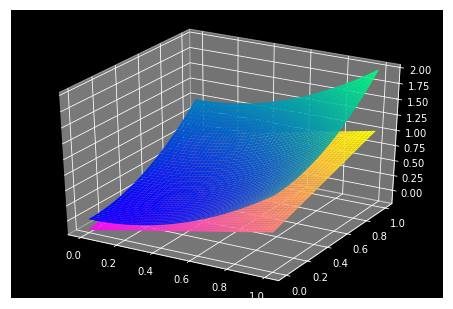

In [9]:
def f(x, y):
    """Fonction f avec laquelle on travaille"""
    return np.power(x,2) + np.power(y,2)
    #return np.exp(-10*(np.power(x-0.5,2)+np.power(y-0.5,2)))


#Création du graphe en 3D
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 1)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

#Test de tracé du plan tg en un point (x0,y0)
x0,y0 = 0.3,0.3
planEnM = creerPlanTg(f, x0, y0)
ax.plot_surface(X, Y, planEnM(X,Y), cmap='spring')

### Méthodologie
On va pour résoudre ce problème :
- commencer en partant d'un point $(x_0,0, z_0)$ trouvé sur l'arrête gauche en utilisant le TVI comme précédemment, où $z_0 = c$. On note ce point $M_0 = (x_0,y_0, z_0)$ avec donc $y_0 = 0$
- On va alors, pour créer le point $M_1 = (x_1,y_1, z_1)$, regarder la droite formée par l'intersection du plan tangent à $f$ en $M_0$ et le plan d'équation $z=c$. On trouve alors exactement deux points se situant à une distance $\delta$ de $M_0$, mais à moins d'être dans le cas particulier (donc impossible en pratique) ou la droite est parallèle à l'axe des abscisses, un seul de ces deux points possède une coordonnée $x$ positive (plus généralement, un seul de ces deux points est dans le domaine). On note alors ce point $M_1$.
- On réutilise la même méthode pour construire ainsi par récurence la suite de points $(M_n)$ qui donne une bonne approximation de la courbe de niveau (approximation d'autant meilleur que $\delta$ est petit). Il n'y a jamais de problème de choix entre les deux points possibles sur la droite car l'un d'entre eux est $M_{n-1}$, donc il suffit de prendre l'autre.


Mathématiquement, la droite $D$ décrite ci dessus possède les caractéristiques suivantes :
$$\forall (x,y,z) \in D, \left\{
    \begin{array}{ll}
        \frac{\partial f}{\partial x}(M_0) \times (x-x_0) + \frac{\partial f}{\partial y}(M_0) \times (y-y_0) = 0 \textit{ (appartient au plan tangent à $f$ en $M_0$)}\\
        z - z_0 = 0 \textit{ (appartient au plan d'équation $z = c$ par définition d'une courbe de niveau)}
    \end{array}
\right.$$

Donc si l'on cherche les points éloignés de $\delta$ de $M_0$, ce qui se traduit par $(x-x_0)^2 + (y-y_0)^2 = \delta ^2$, on se retrouve à résoudre un système de la forme :
$$\lambda a + \mu b = 0 \text{ et } a^2 + b^2 = \delta ^2$$
Sous réserve que $\lambda$ et $\mu$ soient non nuls (toujours le cas en pratique, comme ce sont les coordonnées du gradient de $f$ en $M_0$), se système se résout et l'on trouve alors deux couples de solutions qui sont les suivants :

$$\left\{
    \begin{array}{ll}
        a = -\eta \mu \\
        b = \eta \lambda
    \end{array}
\right.
\text{ ou }
\left\{
    \begin{array}{ll}
        a = \eta \mu \\
        b = -\eta \lambda
    \end{array}
\right. 
\text{ avec } \eta = \frac{\delta}{\sqrt{\lambda^2 + \mu^2}}$$


On garde, pour le cas ou l'on cherche $M_1$, celle telle que $y_1 >0$, et pour les cas ou l'on cherche $M_{n+1}$ celle qui n'est pas $M_{n-1}$ (ce qui en pratique se fait en reardant le point le plus éloigné de $M_{n-1}$ entre les deux points candidats).

### Implémentation

On commence donc par définir les fonctions de RecherchedeM0 qui seront là pour trouver le point de départ sur lequel travaillé, d'abord celle de l'énoncé en partant de l'arrête gauche en utilisant donc une méthode de type dichotomie, mais aussi les autres sur le même principe.

In [16]:
#Fonction de test
def RechercheM0ArreteGauche(f, c):
    return (0, find_seed(lambda t : f(0,t), c))

def RechercheM0ArreteDroite(f, c):
    return (1, find_seed(lambda t : f(1,t), c))


def RechercheM0ArreteHaute(f, c):
    return (find_seed(lambda t : f(t,1), c), 1)


def RechercheM0ArreteBasse(f, c):
    return (find_seed(lambda t : f(t,0), c), 0)
    

In [0]:
On définit à présent des fonctions utiles qui vont nous permettre de mettre en place `simple_contour`

In [17]:
def DansLeDomaine(M):
    """Vérifie si le point M est dans le domaine [0,1]^2"""
    if M[0] >= 0 and M[0] <= 1:
        if M[1] >= 0 and M[1] <= 1:
            return True
    return False


def ProchainsPointsPotentiels(gradf, M, c, delta):
    """Retourne les deux candidats pour le rôle de Mn+1 en se basant sur Mn, en éploitant le calcul théorique précédent"""
    gradfEnM = gradf(M[0],M[1])
    l, mu = gradfEnM[0], gradfEnM[1]
    eta = delta/(np.sqrt(l**2 + mu**2))
    return ((M[0] - eta*mu, M[1] + eta*l),(M[0] + eta*mu, M[1] - eta*l))


def ChoisirPointPlusEloigne(ListeM, MRepere):
    """Retourne parmi une liste de 2 points ListeM le plus éloigné de MRepere"""
    a = (ListeM[0][0] - MRepere[0])**2 + (ListeM[0][1] - MRepere[1])**2
    b = (ListeM[1][0] - MRepere[0])**2 + (ListeM[1][1] - MRepere[1])**2
    if a > b:
        return ListeM[0]
    else:
        return ListeM[1]

In [0]:
On implémente donc une finction `simple_contour(f, c=0.0, delta=0.01, RechercheM0)`.
La fonction `f` est la fonction à deux variables dont nous cherchons une ligne de niveau de hauteur c.
Le paramètre `delta` vient définir l'écart entre les points que nous allons trouver.
Enfin, le paramètre supplémentaire `RechercheM0` est une fonction retournant le point M0 que nous allons utiliser comme point de départ.

In [20]:
def simple_contour(f, c=0.0, delta=0.01, RechercheM0 = RechercheM0ArreteGauche):
    """Methode donnant la ligne de niveau de la fonction f a la hauteur c sur le domaine [0,1]^2
    Il est indispensable qu'il existe un point t tel que f(t,0) = c
    L'argument fonction de recherche donne une fonction visant à trouver la position du point M0 à utilisée"""
    gradf = grad(f)

    #Liste qui contiendra les points que nous trouvons appartenant à la courbe de niveau
    M = []
    
    #On commence par trouver M0, et l'on retourne une liste vide si jamais l'algorithme plante
    try :
        M.append(RechercheM0(f,c))
    except ValueError:
        return ([],[])

    #On en déduit alors le point M1, c'est à dire le seul point écarté de delta de M0 sur la droite D qui est dans le domaine
    M1Potentiels = ProchainsPointsPotentiels(gradf, M[0], c, delta)
    if DansLeDomaine(M1Potentiels[0]) :
        M.append(M1Potentiels[0])
    elif DansLeDomaine(M1Potentiels[1]) :
        M.append(M1Potentiels[1])
    else:
        raise ValueError("Aucun point M1 trouvé dans le domaine : erreur de calcul quelque part")

    #On lance alors l'algorithme de recherche récursif dans la limite d'un nombre N de points max
    N = 10000
    for n in range(1,N):
        #On trouve les deux points potentiels au role de Mn+1 à partir de la position de Mn
        Mnp1Potentiels = ProchainsPointsPotentiels(gradf, M[n], c, delta)

        #On choisit celui des deux qui est le plus éloigné de Mn-1 :
        Mnp1 = ChoisirPointPlusEloigne(Mnp1Potentiels, M[n-1])

        #On vérifie que le point est toujours dans le domaine, sinon on arrête
        if not DansLeDomaine(Mnp1):
            break;

        #On vérifie également que le point n'est pas confondu avec un des autres points deja calculés, sinon c'est que l'on boucle
        for Mi in M[:-1]:
            if (Mi[0] - Mnp1[0])**2 + (Mi[1] - Mnp1[1])**2 <= delta**2:
                break;

        #On peut continuer, et on ajoute notre point à la suite
        M.append(Mnp1)

    #La fin du programme devant retourner une liste de coordonée x et y, on décompose les coordonnées des points
    return ([Mi[0] for Mi in M], [Mi[1] for Mi in M])




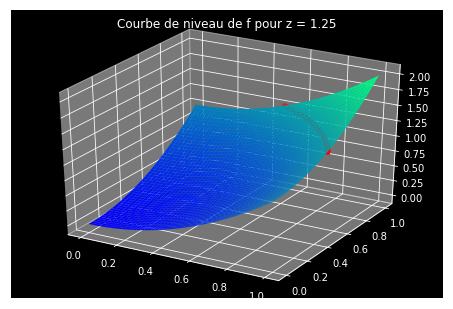

In [30]:
#Premier essais
z0 = 1.25
courbeX,courbeY = simple_contour(f, c=z0, RechercheM0=RechercheM0ArreteHaute)

#Création du graphe en 3D
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 1)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

#On trace la courbe de niveau
ax.scatter(courbeX, courbeY, z0, c="red")
ax.set_title(f"Courbe de niveau de f pour z = {z0}")

In [143]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    #Création de la division du domaine
    pairesX = [(xc[k],xc[k+1]) for k in range(len(xc)-1)]
    pairesY = [(yc[k],yc[k+1]) for k in range(len(yc)-1)]
    carres = []
    for X in pairesX:
        for Y in pairesY:
            carres.append((X,Y))
            
    #Listes qui vont contenir tous les points
    LX, LY = [], []
    for carre in carres:
        #On normalise la fonction f pour s'adapter au carre dans lequel on évolue
        x0,x1,y0,y1 = carre[0][0], carre[0][1], carre[1][0], carre[1][1]
        LXn, LYn, Ltemp = [],[], []
        g = lambda x,y : f(x0 + (x1-x0)*x, y0 + (y1-y0)*y)
        
        #Recherche sur l'arrête gauche
        Ltemp = simple_contour(g, c, delta)
        LXn += Ltemp[0]
        LYn += Ltemp[1]
        
        #Recherche sur l'arrête basse
        #Ltemp = simple_contour(lambda x,y: g(y,x), c, delta)
        #LXn += Ltemp[0]
        #LYn += Ltemp[1]
        
        
        #Recherche sur l'arrête droite
        #Ltemp = simple_contour(lambda x,y: g(1-x,y), c, delta)
        #LXn += Ltemp[0]
        #LYn += Ltemp[1]
        
        #Recherche sur l'arrête haute
        #Ltemp = simple_contour(lambda x,y: g(1-y,x), c, delta)
        #LXn += [1-y for y in Ltemp[1]]
        #LYn += Ltemp[0]
        
        #On "dénormalise" les points
        LX += [x0 + (x1-x0)*x for x in LXn]
        LY += [y0 + (y1-y0)*y for y in LYn]
        
    return LX, LY


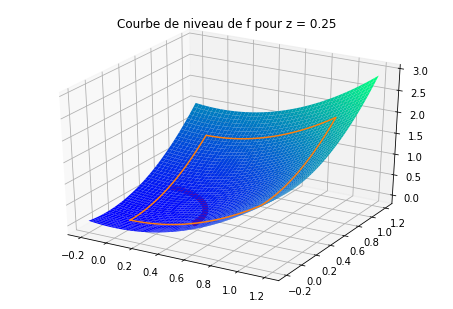

In [147]:
#Premier essais
z0 = f(0,0.5)
courbeX,courbeY = contour(f, c=z0)

#Création du graphe en 3D
domain_x = np.linspace(0 - 0.2, 1 + 0.2)   
domain_y = np.linspace(0 - 0.2, 1 + 0.2)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

#On trace les contours
Contours = [(0,y) for y in np.linspace(0,1,1000)]
Contours += [(x,1) for x in np.linspace(0,1,1000)]
Contours += [(1,1-y) for y in np.linspace(0,1,1000)]
Contours += [(1-x,0) for x in np.linspace(0,1,1000)]
ax.plot([e[0] for e in Contours], [e[1] for e in Contours], [f(e[0],e[1]) for e in Contours])

#On trace la courbe de niveau
ax.scatter(courbeX, courbeY, z0, c="red")
ax.set_title(f"Courbe de niveau de f pour z = {z0}")

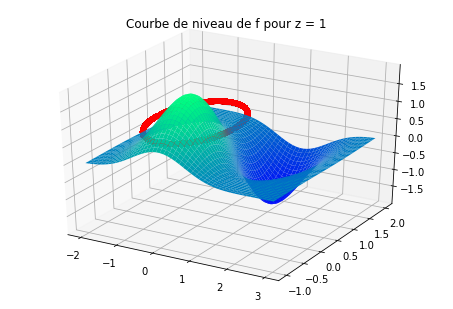

In [153]:
def f2(x,y):
    return 2*(np.exp(-np.power(x,2)-np.power(y,2)) - np.exp(-np.power(x-1,2)-np.power(y-1,2)))

#Création du graphe en 3D
domain_x = np.linspace(-2,3)   
domain_y = np.linspace(-1,2)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f2(X, Y), cmap='winter')

#ON trace la ligne de niveau
z0 = 1
courbeX,courbeY = contour(f, c=z0, xc = np.linspace(-2,3,1000), yc = np.linspace(-1,2,1000))
ax.scatter(courbeX, courbeY, z0, c="red")
ax.set_title(f"Courbe de niveau de f pour z = {z0}")

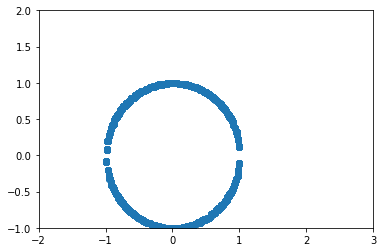

In [151]:
courbeX,courbeY = contour(f, c=1, xc = np.linspace(-2,3,300), yc = np.linspace(-1,2,300))
plt.scatter(courbeX, courbeY)
plt.xlim(-2,3)
plt.ylim(-1,2)
plt.show()